In [ ]:
import os
import numpy as np
from google.colab import drive

# Mount Google Drive if not already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Define the directory in Google Drive where the data splits are saved
drive_save_path_splits = '/content/drive/MyDrive/cremad_data_splits'

# Load the split data
X_train = np.load(os.path.join(drive_save_path_splits, 'X_train.npy'))
X_val = np.load(os.path.join(drive_save_path_splits, 'X_val.npy'))
X_test = np.load(os.path.join(drive_save_path_splits, 'X_test.npy'))
y_train = np.load(os.path.join(drive_save_path_splits, 'y_train.npy'))
y_val = np.load(os.path.join(drive_save_path_splits, 'y_val.npy'))
y_test = np.load(os.path.join(drive_save_path_splits, 'y_test.npy'))

# Get the input shape and number of classes
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print("Data splits loaded successfully from Google Drive.")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

Mounted at /content/drive
Data splits loaded successfully from Google Drive.
X_train shape: (4464, 128, 216, 1)
X_val shape: (1489, 128, 216, 1)
X_test shape: (1489, 128, 216, 1)
y_train shape: (4464,)
y_val shape: (1489,)
y_test shape: (1489,)


In [ ]:
# Reshape the input data to have 3 channels
X_train = np.repeat(X_train, 3, axis=-1)
X_val = np.repeat(X_val, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

print("Data reshaped to 3 channels.")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

Data reshaped to 3 channels.
X_train shape: (4464, 128, 216, 3)
X_val shape: (1489, 128, 216, 3)
X_test shape: (1489, 128, 216, 3)


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import numpy as np

# Load the ResNet50 model pre-trained on ImageNet, excluding the top dense layer
input_shape_3_channels = (input_shape[0], input_shape[1], 3)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape_3_channels)

for layer in resnet_model.layers:
    layer.trainable = False

for layer in resnet_model.layers[-4:]: # Unfreeze the last 4 layers
    layer.trainable = True

# Add custom layers on top of the pre-trained model
x = Flatten()(resnet_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

# Create the new model
resnet_model = Model(inputs=resnet_model.input, outputs=x)

# Print the model summary
resnet_model.summary()

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Compile the ResNet model
resnet_model.compile(optimizer=Adam(),
                     loss=SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])

print("ResNet model compiled successfully.")

ResNet model compiled successfully.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Train the model
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
resnet_history = resnet_model.fit(X_train, y_train,
                                   epochs=20,
                                   batch_size=32,
                                   validation_data=(X_val, y_val))

# resnet_history = resnet_model.fit(X_train, y_train,
#                                    epochs=30,
#                                    batch_size=32,
#                                    validation_data=(X_val, y_val),
#                                   callbacks = [early_stop])

print("ResNet model training completed.")

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 42s 180ms/step - accuracy: 0.2172 - loss: 3.4262 - val_accuracy: 0.1699 - val_loss: 1.7859
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.2368 - loss: 1.7438 - val_accuracy: 0.2565 - val_loss: 1.6948
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.2434 - loss: 1.7064 - val_accuracy: 0.2639 - val_loss: 1.6405
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.2566 - loss: 1.7045 - val_accuracy: 0.2364 - val_loss: 1.7153
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.2807 - loss: 1.6915 - val_accuracy: 0.2787 - val_loss: 1.7231
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.2725 - loss: 1.6801 - val_accuracy: 0.3210 - val_loss: 1.6419
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.2769 - loss: 1.6735 - val_accuracy: 0.3217 - val_loss: 1.6415
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.2821 - loss: 1.6591 -

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

def evaluate_and_plot(model, X_test, y_test, history):
    """
    Evaluates a trained model on test data, prints the classification report,
    and plots the training history.

    Args:
        model: The trained Keras model.
        X_test: The test features.
        y_test: The true test labels.
        history: The training history object returned by model.fit().
    """
    # Evaluate the model on the test data
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Predict the classes for the test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generate and print the classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes))

    # Plot training history
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

Test Loss: 1.5516
Test Accuracy: 0.3559
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       262
           1       0.28      0.12      0.17       259
           2       0.35      0.90      0.50       274
           3       0.28      0.49      0.35       228
           4       0.00      0.00      0.00       244
           5       0.54      0.64      0.59       222

    accuracy                           0.36      1489
   macro avg       0.24      0.36      0.27      1489
weighted avg       0.24      0.36      0.26      1489



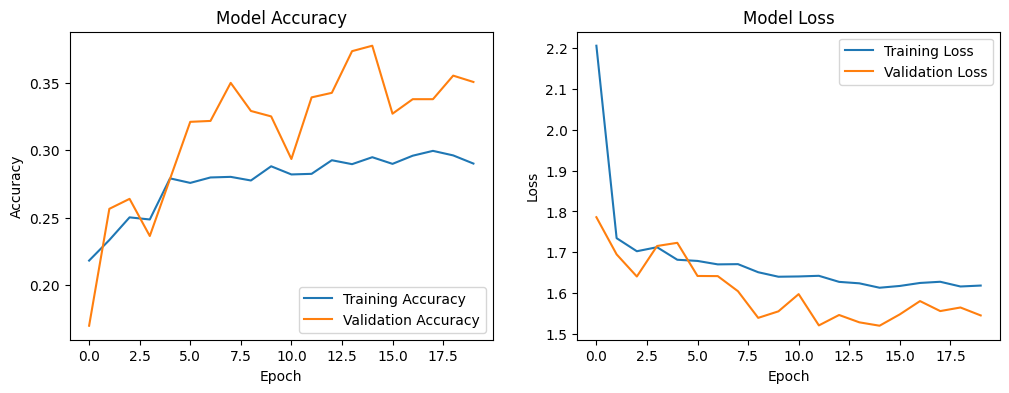

In [ ]:
evaluate_and_plot(resnet_model, X_test, y_test, resnet_history)

# Leaky Relu

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, LeakyReLU
from tensorflow.keras.models import Model
import numpy as np

# Load the ResNet50 model pre-trained on ImageNet, excluding the top dense layer
input_shape_3_channels = (input_shape[0], input_shape[1], 3)
resnet_model2 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape_3_channels)

for layer in resnet_model2.layers:
    layer.trainable = False

for layer in resnet_model2.layers[-4:]: # Unfreeze the last 4 layers
    layer.trainable = True

# Add custom layers on top of the pre-trained model
x = Flatten()(resnet_model2.output)
x = Dense(256)(x)
x = LeakyReLU(negative_slope=0.01)(x) # Use LeakyReLU activation
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

# Create the new model
resnet_model2 = Model(inputs=resnet_model2.input, outputs=x)

# Print the model summary
resnet_model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 216,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 222,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 108,   │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 108,   │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 108,   │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 110,   │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 54,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 54,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 54,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 54,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 54,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 54,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 54,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 54,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 54,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 54,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 54,    │      1,024 │ conv2_block1_3_c

 Total params: 38,269,574 (145.99 MB)

 Trainable params: 15,736,582 (60.03 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Compile the ResNet model
resnet_model2.compile(optimizer=Adam(),
                     loss=SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])

print("ResNet model compiled successfully.")

ResNet model compiled successfully.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Train the model
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
resnet_history2 = resnet_model2.fit(X_train, y_train,
                                   epochs=20,
                                   batch_size=32,
                                   validation_data=(X_val, y_val))

# resnet_history = resnet_model.fit(X_train, y_train,
#                                    epochs=30,
#                                    batch_size=32,
#                                    validation_data=(X_val, y_val),
#                                   callbacks = [early_stop])

print("ResNet model training completed.")

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 40s 176ms/step - accuracy: 0.2595 - loss: 3.7938 - val_accuracy: 0.3015 - val_loss: 1.6529
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.3287 - loss: 1.6144 - val_accuracy: 0.3667 - val_loss: 1.5879
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.3423 - loss: 1.6066 - val_accuracy: 0.3566 - val_loss: 2.1595
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.3710 - loss: 1.5339 - val_accuracy: 0.3848 - val_loss: 1.5474
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.3730 - loss: 1.5231 - val_accuracy: 0.4224 - val_loss: 1.4363
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.3883 - loss: 1.5132 - val_accuracy: 0.3942 - val_loss: 1.4807
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.3707 - loss: 1.5027 - val_accuracy: 0.4406 - val_loss: 1.4074
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.3900 - loss: 1.5031 -

Test Loss: 1.4754
Test Accuracy: 0.4150
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.50      0.40       262
           1       0.40      0.20      0.26       259
           2       0.49      0.65      0.56       274
           3       0.45      0.02      0.04       228
           4       0.32      0.37      0.34       244
           5       0.51      0.73      0.60       222

    accuracy                           0.42      1489
   macro avg       0.42      0.41      0.37      1489
weighted avg       0.42      0.42      0.37      1489



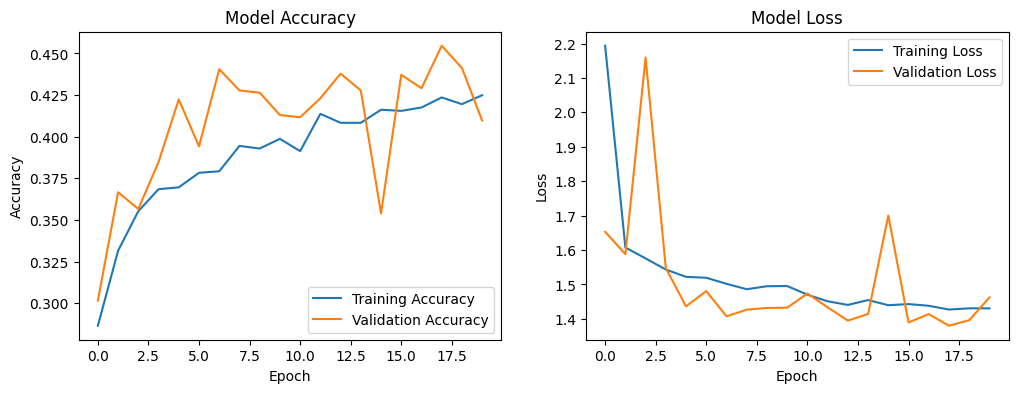

In [ ]:
evaluate_and_plot(resnet_model2, X_test, y_test, resnet_history2)

# Learning Rate Variation


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import numpy as np

# Load the ResNet50 model pre-trained on ImageNet, excluding the top dense layer
input_shape_3_channels = (input_shape[0], input_shape[1], 3)
resnet_model3 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape_3_channels)

for layer in resnet_model3.layers:
    layer.trainable = False

for layer in resnet_model3.layers[-4:]: # Unfreeze the last 4 layers
    layer.trainable = True

# Add custom layers on top of the pre-trained model
x = Flatten()(resnet_model3.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

# Create the new model
resnet_model3 = Model(inputs=resnet_model3.input, outputs=x)

# Print the model summary
resnet_model3.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 216,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 222,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 108,   │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 108,   │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 108,   │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 110,   │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 54,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 54,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 54,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 54,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 54,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 54,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 54,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 54,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 54,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 54,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 54,    │      1,024 │ conv2_block1_3_c

 Total params: 38,269,574 (145.99 MB)

 Trainable params: 15,736,582 (60.03 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Compile the ResNet model with an increased learning rate
resnet_model3.compile(optimizer=Adam(learning_rate=0.01), # Increased learning rate
                     loss=SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])

print("ResNet model compiled successfully.")

ResNet model compiled successfully.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Train the model
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
resnet_history3 = resnet_model3.fit(X_train, y_train,
                                   epochs=20,
                                   batch_size=32,
                                   validation_data=(X_val, y_val))

# resnet_history = resnet_model.fit(X_train, y_train,
#                                    epochs=30,
#                                    batch_size=32,
#                                    validation_data=(X_val, y_val),
#                                   callbacks = [early_stop])

print("ResNet model training completed.")


Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 38s 170ms/step - accuracy: 0.1890 - loss: 13.1346 - val_accuracy: 0.1699 - val_loss: 1.7898
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.1799 - loss: 1.7905 - val_accuracy: 0.1652 - val_loss: 1.7901
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.1661 - loss: 1.7894 - val_accuracy: 0.1652 - val_loss: 1.7915
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.1758 - loss: 1.7902 - val_accuracy: 0.1652 - val_loss: 1.7909
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.1727 - loss: 1.7937 - val_accuracy: 0.1652 - val_loss: 1.7916
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.1878 - loss: 1.7895 - val_accuracy: 0.1659 - val_loss: 1.7910
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.1695 - loss: 1.7922 - val_accuracy: 0.1652 - val_loss: 1.7931
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.1839 - loss: 1.7898 - va

NameError: name 'evaluate_and_plot' is not defined

Test Loss: 1.7941
Test Accuracy: 0.1491
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       262
           1       0.00      0.00      0.00       259
           2       0.00      0.00      0.00       274
           3       0.00      0.00      0.00       228
           4       0.00      0.00      0.00       244
           5       0.15      1.00      0.26       222

    accuracy                           0.15      1489
   macro avg       0.02      0.17      0.04      1489
weighted avg       0.02      0.15      0.04      1489



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


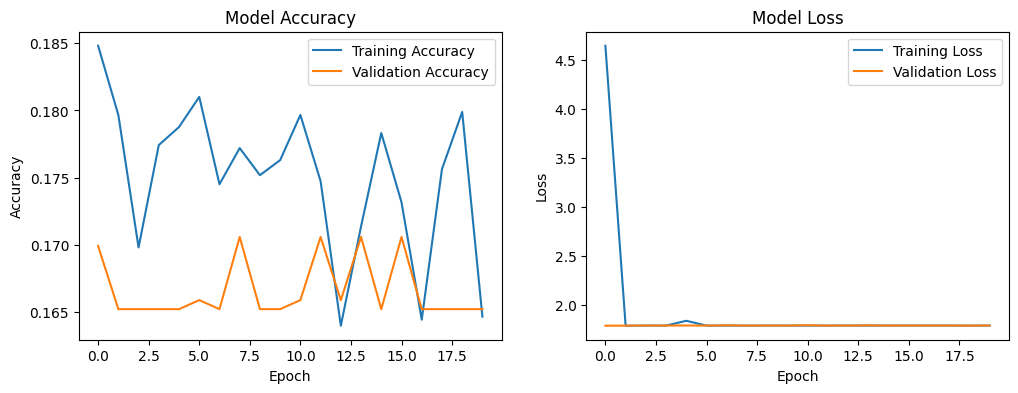

In [ ]:
evaluate_and_plot(resnet_model3, X_test, y_test, resnet_history3)